# Project 2 Notebook

Imported necessary libraries

In [1]:
# Your code here - remember to use markdown cells for comments as well!
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import statsmodels
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from statsmodels.tools.eval_measures import rmse
from statsmodels.api import qqplot
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from folium.plugins import FastMarkerCluster
import folium
from sklearn.metrics import r2_score

In [2]:
housedf = pd.read_csv('data/kc_house_data.csv')


In [3]:
housedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [4]:
housedf.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [5]:
housedf.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [6]:
dfinit = housedf.drop(['id', 'date', 'yr_renovated', 'condition', 'waterfront', 'lat', 'long', 
                 'sqft_above', 'sqft_basement', 'view'], axis=1).copy()

dfrev1 = dfinit.drop(['sqft_living15', 'sqft_lot15'], axis=1).copy()
dfrev1.drop_duplicates(keep='first', inplace=True)
dfrev1

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,yr_built,zipcode
0,221900.0,3,1.00,1180,5650,1.0,7 Average,1955,98178
1,538000.0,3,2.25,2570,7242,2.0,7 Average,1951,98125
2,180000.0,2,1.00,770,10000,1.0,6 Low Average,1933,98028
3,604000.0,4,3.00,1960,5000,1.0,7 Average,1965,98136
4,510000.0,3,2.00,1680,8080,1.0,8 Good,1987,98074
...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,1131,3.0,8 Good,2009,98103
21593,400000.0,4,2.50,2310,5813,2.0,8 Good,2014,98146
21594,402101.0,2,0.75,1020,1350,2.0,7 Average,2009,98144
21595,400000.0,3,2.50,1600,2388,2.0,8 Good,2004,98027


In [7]:
spatialdf = pd.read_excel('data/demographic_spatial_join.xls')
# print('Number of Homes Removed:',housedf.shape[0] - housedf_cleaned.shape[0],'| Percent of Homes Removed:', round((df.shape[0] - df_cleaned.shape[0])/df.shape[0]*100,2))
pd.set_option('display.max_columns', None)
spatialdf.head()

,OBJECTID,ZCTA5CE10,GEOID10,POP2000,POP2001,POP2002,POP2003,POP2004,POP2005,POP2006,POP2007,POP2008,POP2009,POP2010,POP2011,POP2012,POP2013,POP2014,POP2015,POP2016,POP2017,POP2018,POP2019,sum_totale,sum_number,mean_numbe,mean_month,mean_heatb,sum_childr,sum_senior,sum_disabl,sum_vulner,mean_shelt,mean_heatc,mean_annua,mean_energ,sum_miltar,sum_racena,sum_raceas,sum_racebl,sum_racepa,sum_racewh,sum_racemu,sum_raceun,sum_raceot,sum_ethnic,sum_ethn_1,sum_ethn_2,sum_edunde,sum_edhigh,sum_edsome,sum_edunsp,sum_electr,sum_natura,sum_oil,sum_coal,sum_propan,sum_wood,sum_houset,sum_hous_1,sum_hous_2,sum_hous_3,sum_hous_4,sum_ownedo,sum_subsid,sum_rental,sum_roomer,sum_tempor,STATE,COUNTY,TRACT,ALAND,AWATER,ALAND_SQMI,Total_AGE,POPDENSITY,M_21,M_22to24,M_25to29,M_30to34,M_35to39,M_40to44,M_45to49,M_50to54,M_55to59,M_60to61,M_62to64,M_65to66,M_67to69,M_70to74,M_75to79,M_80to84,M_Over85,F_21,F_22to24,F_25to29,F_30to34,F_35to39,F_40to44,F_45to49,F_50to54,F_55to59,F_60to61,F_62to64,F_65to66,F_67to69,F_70to74,F_75to79,F_80to84,F_Over85,Total_21to,Total_35to,Total_55to,Over69,Over65,Over85,Per_21to34,Per_35to54,Per_55to69,Per_Over69,Per_Over65,Per_Over85,Income,juddst,NAME,Shape_Length,Shape_Area
0,1,98001,5398001,26119.972,26684.217,27303.193,27745.212,28217.911,28712.617,29461.151,30143.274,30731.948,31288.902,31911,32003.454,32232.317,32645.465,33322.573,33576.434,34107.383,34739.821,35399.577,35947.587,643993,4060,3.011869,1390.411721,4.180148,287,517,565,1006,625.286736,655.120920,1000.485853,1163.667263,1,147,260,1072,56,1966,559,0,0,0,355,3705,413,1042,491,2114,837,491,17,0,3,0,657,274,377,40,0,266,815,267,0,0,53,33,,5479235795,495559529,2115.544768,2045756,967.011444,12755,42907,88406,87845,79150,77804,73915,73446,66523,23749,32272,18021,21658,25552,16893,12101,12116,11746,42730,84332,83774,74963,74861,71711,72638,68388,25395,33935,20079,24054,29477,21606,17096,23707,454495,598488,334074,158548,242360,35823,22.216481,29.255102,16.3301,7.750093,11.846965,1.751089,75302,SE,Southeast,0.432608,1.307868e+10
1,2,98001,5398001,26119.972,26684.217,27303.193,27745.212,28217.911,28712.617,29461.151,30143.274,30731.948,31288.902,31911,32003.454,32232.317,32645.465,33322.573,33576.434,34107.383,34739.821,35399.577,35947.587,643993,4060,3.011869,1390.411721,4.180148,287,517,565,1006,625.286736,655.120920,1000.485853,1163.667263,1,147,260,1072,56,1966,559,0,0,0,355,3705,413,1042,491,2114,837,491,17,0,3,0,657,274,377,40,0,266,815,267,0,0,53,33,,5479235795,495559529,2115.544768,2045756,967.011444,12755,42907,88406,87845,79150,77804,73915,73446,66523,23749,32272,18021,21658,25552,16893,12101,12116,11746,42730,84332,83774,74963,74861,71711,72638,68388,25395,33935,20079,24054,29477,21606,17096,23707,454495,598488,334074,158548,242360,35823,22.216481,29.255102,16.3301,7.750093,11.846965,1.751089,75302,SW,Southwest,0.432608,1.307868e+10
2,3,98002,5398002,30243.492,30366.900,30552.156,30541.121,30568.173,30622.163,30945.394,31194.423,31345.018,31463.410,31647,31874.065,31989.726,32337.260,32637.807,32827.303,33461.492,34308.728,34795.087,35105.655,1390246,8439,2.656280,1288.760781,3.637879,825,787,1363,2351,681.880183,560.182247,822.277013,1050.015681,27,367,161,2091,598,3949,1273,0,0,0,843,7596,828,2368,1096,4147,2571,599,0,0,3,4,745,1514,631,284,3,403,1587,1187,0,0,53,33,,5479235795,495559529,2115.544768,2045756,967.011444,12755,42907,88406,87845,79150,77804,73915,73446,66523,23749,32272,18021,21658,25552,16893,12101,12116,11746,42730,84332,83774,74963,74861,71711,72638,68388,25395,33935,20079,24054,29477,21606,17096,23707,454495,598488,334074,158548,242360,35823,22.216481,29.255102,16.3301,7.750093,11.846965,1.751089,75302,SE,Southeast,0.330129,1.307868e+10
3,4,98003,5398003,41999.105,42190.747,42468.348,42473.056,42530.519,42625.337,43095.002,43461.506,43690.958,43875.495,44151,44238.495,44280.672,44383.779,44652.480,44994.294,47127.228,48911.888,49466.731,49586.838,2533612,15201,2.718834,1261.577893,3.524262,1552,1612,2582,4407,618.857090,564.706493,

### Change the zipcode from numbers to area bins

In [8]:
kc_zips = [98178, 98125, 98028, 98136, 98074, 98053, 98003, 98198,
           98146, 98038, 98007, 98115, 98107, 98126, 98019, 98103, 
           98002, 98133, 98040, 98092, 98030, 98119, 98112, 98052, 
           98027, 98117, 98058, 98001, 98056, 98166, 98023, 98070, 
           98148, 98105, 98042, 98008, 98059, 98122, 98144, 98004, 
           98005, 98034, 98075, 98116, 98010, 98118, 98199, 98032, 
           98045, 98102, 98077, 98108, 98168, 98177, 98065, 98029, 
           98006, 98109, 98022, 98033, 98155, 98024, 98011, 98031, 
           98106, 98072, 98188, 98014, 98055, 98039]

In [9]:
# Extract zipcode and court district from spatial DF
b_series = spatialdf.ZCTA5CE10.isin(kc_zips)
df_zips = spatialdf[b_series]
df_names = df_zips[['ZCTA5CE10', 'NAME']]

# Remove duplicates, because some zipcodes split court districts
df_names.drop_duplicates(subset=['ZCTA5CE10'], inplace=True)
df_names.ZCTA5CE10

# lists of zipcodes
northeast = df_names.query('NAME=="Northeast"')['ZCTA5CE10'].to_list()
west = df_names.query('NAME=="West"')['ZCTA5CE10'].to_list()
shoreline = df_names.query('NAME=="Shoreline"')['ZCTA5CE10'].to_list()
southwest = df_names.query('NAME=="Southwest"')['ZCTA5CE10'].to_list()
southeast = df_names.query('NAME=="Southeast"')['ZCTA5CE10'].to_list()

# Apply the bin labels to zipcodes in a new dataframe.
dfrev2 = dfrev1.copy()

dfrev2['zipcode'] = dfrev2.zipcode.replace(to_replace=northeast, value = "Northeast")
dfrev2['zipcode'] = dfrev2.zipcode.replace(to_replace=west, value = "West")
dfrev2['zipcode'] = dfrev2.zipcode.replace(to_replace=shoreline, value = "Shoreline")
dfrev2['zipcode'] = dfrev2.zipcode.replace(to_replace=southwest, value = "Southwest")
dfrev2['zipcode'] = dfrev2.zipcode.replace(to_replace=southeast, value = "Southeast")

<ipython-input-9-1f6ef54d3590>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_names.drop_duplicates(subset=['ZCTA5CE10'], inplace=True)


# Correlation and Heatmap Visualization

In [10]:
dfrev1.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,zipcode
price,1.000000,0.308838,0.525936,0.701940,0.089868,0.256952,0.054018,-0.053381
bedrooms,0.308838,1.000000,0.514590,0.578208,0.032453,0.178172,0.155875,-0.154142
bathrooms,0.525936,0.514590,1.000000,0.755827,0.088393,0.502822,0.507240,-0.204785
sqft_living,0.701940,0.578208,0.755827,1.000000,0.173427,0.354342,0.318462,-0.199750
sqft_lot,0.089868,0.032453,0.088393,0.173427,1.000000,-0.004657,0.053093,-0.129583
floors,0.256952,0.178172,0.502822,0.354342,-0.004657,1.000000,0.488982,-0.059709
yr_built,0.054018,0.155875,0.507240,0.318462,0.053093,0.488982,1.000000,-0.347446
zipcode,-0.053381,-0.154142,-0.204785,-0.199750,-0.129583,-0.059709,-0.347446,1.000000


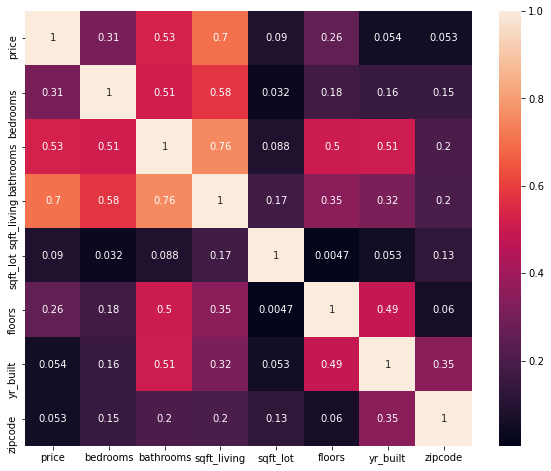

In [11]:
plt.figure(figsize = (10,8))
sns.heatmap(dfrev1.corr().abs(), annot=True);

### Create the train / test split 

In [12]:
y = housedf['price']
X = housedf[['bedrooms','bathrooms','sqft_living','sqft_lot','floors', 'yr_built', 'zipcode']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)

# Model Creation and Application

## Dummy Regressor

In [13]:
#Dummy Regressor

basemodel = DummyRegressor(strategy = 'mean')
basemodel.fit(X_train,y_train)
basemodel.predict(X_train)

array([540946.37500724, 540946.37500724, 540946.37500724, ...,
       540946.37500724, 540946.37500724, 540946.37500724])

In [14]:
basemodel.score(X_train,y_train)

0.0

## StandardScaler and OneHotEncoder

In [15]:
ss = StandardScaler()
ss.fit(X_train)

X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

In [16]:
ohe = OneHotEncoder()
ohe.fit_transform(X_train)

<17277x9569 sparse matrix of type '<class 'numpy.float64'>'
	with 120939 stored elements in Compressed Sparse Row format>

Training Dataset

In [17]:
X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.columns = X.columns
y_train.reset_index(drop=True,inplace=True)
X_train_scaled_final = pd.concat((X_train_scaled, y_train), axis=1)
X_train.reset_index(drop=True, inplace=True)
X_train_final = pd.concat((X_train, y_train), axis=1)

In [18]:
X_train_scaled

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,zipcode
0,-0.404166,-0.148210,-0.591864,-0.174771,-0.917505,1.123192,0.882599
1,0.670108,0.832246,0.489562,-0.020598,0.937801,0.884897,-1.105526
2,-0.404166,0.178609,-0.307853,-0.201845,0.937801,0.408307,-0.824188
3,0.670108,0.505427,0.631567,-0.274556,0.937801,-2.076770,0.507481
4,0.670108,0.832246,2.128085,-0.115790,0.937801,-0.953379,1.857905
...,...,...,...,...,...,...,...
17272,-1.478441,0.178609,-0.482629,-0.309172,0.937801,0.306180,1.032646
17273,1.744382,1.485883,1.319747,-0.208081,0.937801,1.395529,-0.073952
17274,-0.404166,1.485883,1.778533,0.567548,0.937801,0.918939,-1.199306
17275,0.670108,-0.475029,-0.602787,-0.151807,0.010148,-0.102325,-0.374046


Test Dataset

In [19]:
#Test 
X_test_scaled = pd.DataFrame(X_test_scaled)
X_test_scaled.columns = X.columns
y_test.reset_index(drop=True,inplace=True)
X_test_scaled_final = pd.concat((X_test_scaled,y_test),axis=1)

In [20]:
X_test_scaled_final

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,zipcode,price
0,0.670108,0.505427,-0.340624,-0.242455,0.937801,1.123192,-0.749164,291500.0
1,-0.404166,-1.455485,-0.985109,-0.242407,0.010148,-0.851253,1.445276,220000.0
2,0.670108,0.505427,0.729878,-0.247290,0.937801,-2.246981,0.469969,1030000.0
3,0.670108,0.505427,0.249245,-0.229740,0.937801,1.089150,-0.073952,651100.0
4,-0.404166,-0.148210,-0.613711,-0.241488,0.937801,0.204054,1.857905,434900.0
...,...,...,...,...,...,...,...,...
4315,0.670108,0.505427,0.434944,0.032147,-0.917505,-0.408705,-0.936723,560000.0
4316,-0.404166,0.505427,-0.646481,-0.303419,2.793107,1.293403,1.032646,348000.0
4317,0.670108,0.505427,0.107239,-0.189203,0.937801,0.612560,-0.355291,464000.0
4318,1.744382,1.159065,1.680222,-0.054440,-0.917505,-0.238494,-1.349353,858000.0


## First Model

In [21]:
formula = 'price ~ sqft_living + bedrooms + floors'
model = ols(formula, X_train_scaled_final).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     5874.
Date:                Tue, 15 Feb 2022   Prob (F-statistic):               0.00
Time:                        11:55:18   Log-Likelihood:            -2.3986e+05
No. Observations:               17277   AIC:                         4.797e+05
Df Residuals:                   17273   BIC:                         4.798e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    5.409e+05   1970.511    274.521      0.000    5.37e+05    5.45e+05
sqft_living  2.882e+05   2530.414    113.894      0.000    2.83e+05    2.93e+05
bedrooms    -5.411e+04   2402.875    -22.520      0.000   -5.88e+04   -4.94e+04
floors       1412.8026   2110.123      0.670      0.503   -2723.252    5548.857
==============================================================================
Omnibus:                    11809.269   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           435749.399
Skew:                           2.803   Prob(JB):                         0.00
Kurtosis:                      26.956   Cond. No.                         2.11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""